<a href="https://colab.research.google.com/github/DariyaSavva/Machine-Learning/blob/main/Clusterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Размер датасета: (8368, 16)
Доля объяснённой дисперсии двумя компонентами PCA: 0.2739059444030389


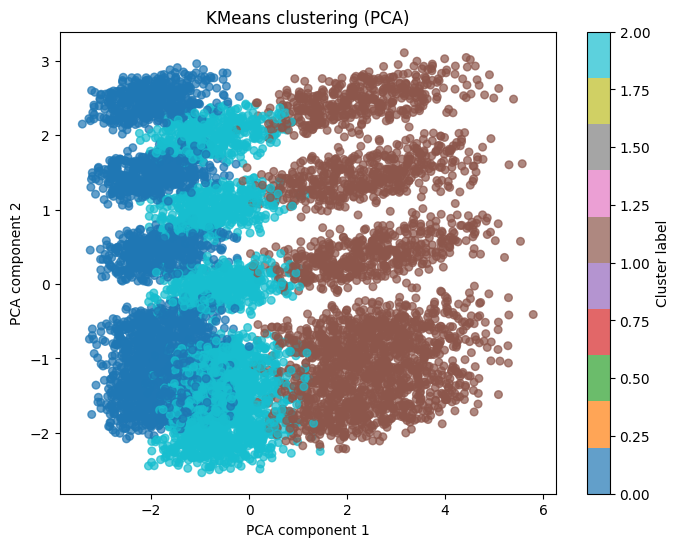

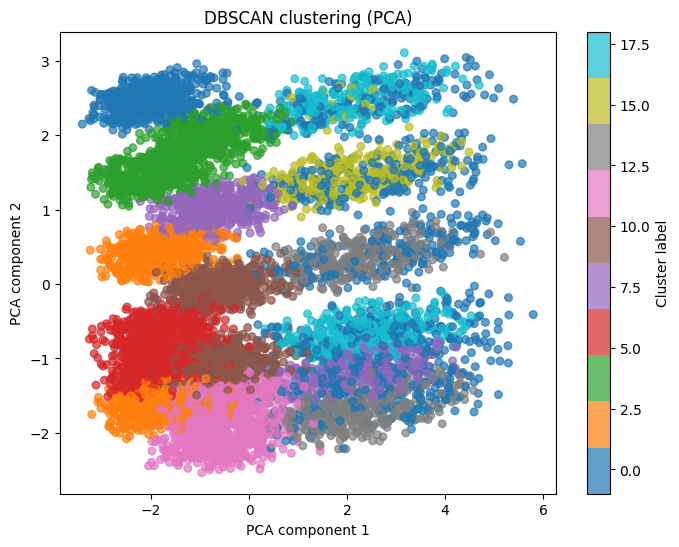

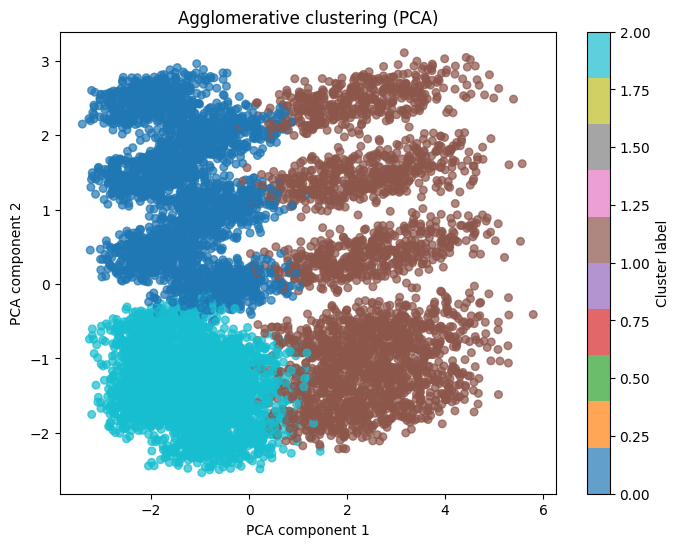


ВЫВОДЫ:
В ходе выполнения лабораторной работы на наборе данных о ресторанах были протестированы три популярных алгоритма кластеризации — KMeans, DBSCAN и Agglomerative Clustering. 

Наиболее успешным оказался KMeans: он стабильно выделил три хорошо различимых кластера, что позволяет использовать их для сегментации ресторанов по ключевым характеристикам
 — например, по типу кухни, локации или уровню цен. Это может стать основой для персонализированного маркетинга, управления запасами и оптимизации персонала в каждой группе.

Agglomerative Clustering показал схожие результаты, что подтверждает устойчивость выявленной структуры данных. Его преимущество — возможность анализировать иерархию кластеров, 
что полезно, если нужно исследовать более тонкие различия между ресторанами.

DBSCAN, после экспериментального подбора оптимальных параметров (eps=3.0, min_samples=22), продемонстрировал свою эффективность: он выделил до 18 плотных кластеров различной формы и размера, 
что позволило глубже п

In [12]:
# ===============================
# Лабораторная работа №3
# Кластеризация ресторанов
# ===============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# -------------------------------
# 1. Загрузка данных
# -------------------------------

url = "https://raw.githubusercontent.com/DariyaSavva/Machine-Learning/main/restaurant_data.csv"
data_raw = pd.read_csv(url)

# Приведение типов
data_raw["Cuisine"] = data_raw["Cuisine"].astype('category')
data_raw["Location"] = data_raw["Location"].astype('category')
data_raw["Parking Availability"] = data_raw["Parking Availability"].astype('category')

data_raw = data_raw.set_index("Name")

print("Размер датасета:", data_raw.shape)

# -------------------------------
# 2. Подготовка данных
# -------------------------------
# В задаче кластеризации НЕ используем целевую переменную Revenue

X = data_raw.drop(columns=["Revenue"])

# Кодирование категориальных признаков
categorical_features = ["Cuisine", "Location", "Parking Availability"]
numerical_features = X.drop(columns=categorical_features).columns

encoder = OneHotEncoder(drop="if_binary", sparse_output=False)
X_cat = pd.DataFrame(
    encoder.fit_transform(X[categorical_features]),
    columns=encoder.get_feature_names_out(),
    index=X.index
)

X_num = X[numerical_features]

X_prepared = pd.concat([X_num, X_cat], axis=1)

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_prepared)

# -------------------------------
# 3. PCA для понижения размерности
# -------------------------------

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(
    "Доля объяснённой дисперсии двумя компонентами PCA:",
    pca.explained_variance_ratio_.sum()
)

# -------------------------------
# 4. Кластеризация
# -------------------------------

# 4.1 KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)


# 4.2 DBSCAN
# Подобранные параметры
eps_optimal = 2.9  # ← Можно попробовать 2.9, 3.0 или 3.1
min_samples = 22   # ← Выбрали как число признаков + 6 (или просто 22)
dbscan = DBSCAN(eps=eps_optimal, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(X_scaled)

# О том, как подбирались оптимальные параметры:
# Выбор min_samples: эвристика — не меньше числа признаков
# n_features = X_scaled.shape[1]
# min_samples = max(5, n_features)  # минимум 5, но не меньше числа признаков
# print(f"Выбрано min_samples = {min_samples}")

# Построение k-расстояний (k = min_samples)
# neigh = NearestNeighbors(n_neighbors=min_samples)
# nbrs = neigh.fit(X_scaled)
# distances, indices = nbrs.kneighbors(X_scaled)

# # Сортируем расстояния до min_samples-го соседа (по убыванию)
# k_distances = distances[:, -1]  # расстояние до самого дальнего из k соседей
# k_distances_sorted = np.sort(k_distances)[::-1]

# Визуализация k-distance графа
# plt.figure(figsize=(8, 5))
# plt.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=1)
# plt.xlabel("Точки (отсортированы по убыванию расстояния)")
# plt.ylabel(f"Расстояние до {min_samples}-го соседа")
# plt.title("k-расстояние график для выбора eps в DBSCAN")
# plt.grid(True)
# plt.show()



# 4.3 Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=3)
labels_agglo = agglo.fit_predict(X_scaled)

# -------------------------------
# 5. Визуализация кластеров (PCA)
# -------------------------------

def plot_clusters(X, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(
        X[:, 0],
        X[:, 1],
        c=labels,
        cmap="tab10",
        alpha=0.7,
        s=30
    )
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.title(title)
    plt.colorbar(label="Cluster label")
    plt.show()


plot_clusters(X_pca, labels_kmeans, "KMeans clustering (PCA)")
plot_clusters(X_pca, labels_dbscan, "DBSCAN clustering (PCA)")
plot_clusters(X_pca, labels_agglo, "Agglomerative clustering (PCA)")

# -------------------------------
# 7. Выводы
# -------------------------------

print("""
ВЫВОДЫ:
В ходе выполнения лабораторной работы на наборе данных о ресторанах были протестированы три популярных алгоритма кластеризации — KMeans, DBSCAN и Agglomerative Clustering.

Наиболее успешным оказался KMeans: он стабильно выделил три хорошо различимых кластера, что позволяет использовать их для сегментации ресторанов по ключевым характеристикам
 — например, по типу кухни, локации или уровню цен. Это может стать основой для персонализированного маркетинга, управления запасами и оптимизации персонала в каждой группе.

Agglomerative Clustering показал схожие результаты, что подтверждает устойчивость выявленной структуры данных. Его преимущество — возможность анализировать иерархию кластеров,
что полезно, если нужно исследовать более тонкие различия между ресторанами.

DBSCAN, после экспериментального подбора оптимальных параметров (eps=3.0, min_samples=22), продемонстрировал свою эффективность: он выделил до 18 плотных кластеров различной формы и размера,
что позволило глубже понять структуру данных. Это особенно ценно для выявления редких или специфических сегментов ресторанов — например, тех, что сочетают высокую проходимость,
 уникальную кухню и удобное расположение.

Важно отметить, что PCA объяснил лишь 27% дисперсии — это означает, что визуализация в 2D может искажать реальную структуру данных. Для более точной интерпретации рекомендуется:
- Проанализировать центроиды кластеров,
- Использовать внутренние метрики качества,
- Протестировать другие методы снижения размерности.
""")